## 📊 Analysing Football Penalty Kick Success Rates Using Python and Statistical Testing

**Competition:** Elite Men’s Football & FIFA World Cup Shootouts  
**Purpose:** Examine the relationship between penalty kick direction and success, including attempt frequency and conversion rates  
**Methods:** Exploratory data analysis, data visualisation, hypothesis testing (two-proportion z-test, chi-square test)  
**Author:** [Victoria Friss de Kereki](https://www.linkedin.com/in/victoria-friss-de-kereki/)  

---

**Notebook first written:** `05/02/2026`  
**Last updated:** `06/02/2026`  

> This notebook investigates whether penalties aimed at the **middle of the goal** are converted at higher rates than those aimed at the sides, and whether they are attempted less frequently. Using datasets from Elite Men’s Football and FIFA World Cup penalty shootouts, the analysis combines **data cleaning, exploratory analysis, heatmap visualisation, and formal statistical testing**.  
>
> Conversion rates and attempt frequencies are computed per goal zone (Left/Centre/Right × Top/Middle/Bottom). Visualisation is achieved through heatmaps overlaid on a goal image with a traffic-light gradient showing high- and low-success areas. Hypothesis tests quantify whether middle penalties are converted at a higher rate and whether they are attempted less often.  
>
> The notebook demonstrates a **reproducible, data-driven workflow** for answering tactical football questions, combining Python, pandas, matplotlib, and standard statistical methods. It can be extended to include player characteristics, match context, or other leagues for further predictive analysis.


<div style="text-align: left;">
    <img src="Images and others/Are Football Penalties to the Middle More Successful A Statistical Analysis.png" alt="Are Football Penalties to the Middle More Successful? A Statistical Analysis" width="600">
</di>
>

# Motivation

A commonly suggested idea in football is that penalty takers avoid shooting down the middle of the goal, despite it being a highly effective option.  
In particular, the following statement, made by my Dad recently, motivated this analysis:

> **“Penalties kicked to the middle are converted way more, though are attempted way less.”**

This analysis tests this claim using penalty outcome data.

---

# Hypotheses

### Conversion rate
- **H₀ (Null)**: Penalties aimed at the middle of the goal are converted at the same or a lower rate than penalties aimed to the left or right.
- **H₁ (Alternative)**: Penalties aimed at the middle of the goal are converted at a higher rate than penalties aimed to the left or right.

---

### Attempt frequency
- **H₀ (Null)**: Penalties are attempted equally often to the middle and to the sides of the goal.
- **H₂ (Alternative)**: Penalties are attempted less often to the middle of the goal than to the sides.


# Import Packages

In [1]:
# Data handling
import pandas as pd           # DataFrames and data manipulation
import pyreadstat             # Reading SPSS/SAS files (.sav, .sas7bdat)

# Statistics
from statsmodels.stats.proportion import proportions_ztest  # Two-proportion z-test
from scipy.stats import chisquare                             # Chi-square test

# Visualization
import matplotlib.pyplot as plt      # Plotting
import matplotlib.image as mpimg     # Loading images
from matplotlib.patches import Rectangle  # Drawing rectangles
import matplotlib.colors as mcolors  # Colormaps and color handling
from matplotlib import colors        # Color normalization (TwoSlopeNorm, etc.)

# MDPI dataset

https://www.mdpi.com/2073-8994/17/9/1570
https://figshare.com/articles/dataset/Dataset_for_Laterality_Shot_Direction_and_Spatial_Asymmetry_in_Decisive_Penalty_Kicks_Evidence_from_Elite_Men_s_Football/29603429?file=60370817

In [2]:
penalty, meta = pyreadstat.read_sav("Datasets/Penalty data/PENALTY_KICKS_ELITE_MENS_FOOTBALL.sav")

In [3]:
len(penalty)

212

In [4]:
meta.value_labels

{'labels0': {1.0: 'CLU', 2.0: 'NT'},
 'labels1': {1.0: 'AW', 2.0: 'HOM', 3.0: 'NA'},
 'labels2': {1.0: 'FIN', 2.0: 'QUA', 3.0: 'R16', 4.0: 'R32', 5.0: 'SEM'},
 'labels3': {1.0: 'FL', 2.0: 'FLC', 3.0: 'SW'},
 'labels4': {1.0: 'FIR', 2.0: 'SEC'},
 'labels5': {1.0: 'LEF', 2.0: 'RIG'},
 'labels6': {2.0: 'LR', 3.0: 'SR', 4.0: 'St'},
 'labels7': {1.0: 'CD',
  2.0: 'CM',
  3.0: 'CT',
  4.0: 'LD',
  5.0: 'LM',
  6.0: 'LT',
  7.0: 'RD',
  8.0: 'RM',
  9.0: 'RT'},
 'labels8': {1.0: 'KICKER-TOP',
  2.0: 'KICKER-MEDIUM',
  3.0: 'KICKER-DOWN',
  4.0: 'MIDDLE-TOP',
  5.0: 'MIDDLE-MEDIUM',
  6.0: 'MIDDLE-DOWN',
  7.0: 'FAR-TOP',
  8.0: 'FAR-MEDIUM',
  9.0: 'FAR-DOWN'},
 'labels9': {1.0: 'FG', 2.0: 'FO', 3.0: 'FS'},
 'labels10': {0.0: 'ERROR', 1.0: 'GOL'}}

In [5]:
penalty = penalty.rename(columns={
    "VAR00011": "id",
    "TIPO_PARTIDO": "match_type",
    "ESTADIO": "stadium_type",
    "RONDA": "competition_round",
    "TIPO_PENALTI": "penalty_type",
    "TURNO": "kick_order",
    "LATERALIDAD": "kicker_foot",
    "CARRERA": "run_up",
    "ZONA": "goal_zone",
    "ZONA_LAT": "goal_side",
    "FINALIZACIÓN": "shot_outcome",
    "EFECTIVIDAD": "goal"
})

In [6]:
# Map SPSS label sets to column names
labelset_to_column = {
    "labels0": "match_type",
    "labels1": "stadium_type",
    "labels2": "competition_round",
    "labels3": "penalty_type",
    "labels4": "kick_order",
    "labels5": "kicker_foot",
    "labels6": "run_up",
    "labels7": "goal_zone",
    "labels8": "goal_sector",
    "labels9": "shot_outcome",
    "labels10": "goal"
}

# Apply labels to dataframe
label_map = {
    col: meta.value_labels[labelset]
    for labelset, col in labelset_to_column.items()
    if labelset in meta.value_labels
}

# Pretty print labels using column names
def show_labels_pretty(meta, mapping):
    for labelset, colname in mapping.items():
        if labelset in meta.value_labels:
            print(f"\n{colname}")
            for k, v in meta.value_labels[labelset].items():
                print(f"  {int(k)} → {v}")

show_labels_pretty(meta, labelset_to_column)

# Optional: build a codebook dataframe
codebook = [
    {"variable": colname, "code": int(k), "label": v}
    for labelset, colname in labelset_to_column.items()
    for k, v in meta.value_labels[labelset].items()
]

codebook_df = pd.DataFrame(codebook)


match_type
  1 → CLU
  2 → NT

stadium_type
  1 → AW
  2 → HOM
  3 → NA

competition_round
  1 → FIN
  2 → QUA
  3 → R16
  4 → R32
  5 → SEM

penalty_type
  1 → FL
  2 → FLC
  3 → SW

kick_order
  1 → FIR
  2 → SEC

kicker_foot
  1 → LEF
  2 → RIG

run_up
  2 → LR
  3 → SR
  4 → St

goal_zone
  1 → CD
  2 → CM
  3 → CT
  4 → LD
  5 → LM
  6 → LT
  7 → RD
  8 → RM
  9 → RT

goal_sector
  1 → KICKER-TOP
  2 → KICKER-MEDIUM
  3 → KICKER-DOWN
  4 → MIDDLE-TOP
  5 → MIDDLE-MEDIUM
  6 → MIDDLE-DOWN
  7 → FAR-TOP
  8 → FAR-MEDIUM
  9 → FAR-DOWN

shot_outcome
  1 → FG
  2 → FO
  3 → FS

goal
  0 → ERROR
  1 → GOL


In [7]:
penalty.head()

,id,match_type,stadium_type,competition_round,penalty_type,kick_order,kicker_foot,run_up,goal_zone,goal_side,shot_outcome,goal
0,1.0,1.0,3.0,1.0,2.0,1.0,2.0,2.0,4.0,3.0,2.0,0.0
1,2.0,1.0,3.0,1.0,3.0,2.0,2.0,2.0,8.0,8.0,1.0,1.0
2,3.0,1.0,2.0,3.0,2.0,2.0,1.0,2.0,8.0,2.0,1.0,1.0
3,4.0,1.0,1.0,3.0,2.0,1.0,1.0,2.0,1.0,6.0,1.0,1.0
4,5.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,3.0,4.0,1.0,1.0


In [8]:
# Total goals
total_goals = (penalty['shot_outcome'] == 1).sum()

# Total attempts
total_attempts = len(penalty)

# Conversion rate
overall_conversion_rate = total_goals / total_attempts
overall_conversion_rate_pct = overall_conversion_rate * 100

print(f"Overall conversion rate: {overall_conversion_rate:.3f} ({overall_conversion_rate_pct:.1f}%)")

Overall conversion rate: 0.675 (67.5%)


In [9]:
# Count shot outcomes per goal zone
outcomes_by_zone = (
    penalty
    .groupby(["goal_zone", "shot_outcome"])
    .size()
    .unstack(fill_value=0)
    .rename(columns={
        1: "goals_FG",
        2: "miss_FO",
        3: "save_FS"
    })
)

# Drop the columns index name
outcomes_by_zone.columns.name = None  # <- this removes "shot_outcome"

# Total attempts
outcomes_by_zone["attempts"] = outcomes_by_zone.sum(axis=1)

# Conversion metrics
outcomes_by_zone["conversion_rate"] = outcomes_by_zone["goals_FG"] / outcomes_by_zone["attempts"]
outcomes_by_zone["conversion_rate_pct"] = (outcomes_by_zone["conversion_rate"] * 100).round(1)

# Sort nicely
outcomes_by_zone = outcomes_by_zone.sort_values(["conversion_rate_pct", "attempts"], ascending=[False, False])

# Make goal_zone a normal column
outcomes_by_zone = outcomes_by_zone.reset_index()

# Adjusted width mapping
outcomes_by_zone["Width"] = outcomes_by_zone["goal_zone"].map({
    1: "C", 2: "C", 3: "C",
    4: "L", 5: "L", 6: "L",
    7: "R", 8: "R", 9: "R"
})

# Adjusted height mapping
outcomes_by_zone["Height"] = outcomes_by_zone["goal_zone"].map({
    1: "D", 4: "D", 7: "D",
    2: "M", 5: "M", 8: "M",
    3: "T", 6: "T", 9: "T"
})

# Final column order
outcomes_by_zone = outcomes_by_zone[
    [
        "goal_zone",
        "Height",
        "Width",
        "goals_FG",
        "miss_FO",
        "save_FS",
        "attempts",
        "conversion_rate",
        "conversion_rate_pct",
    ]
]

outcomes_by_zone

,goal_zone,Height,Width,goals_FG,miss_FO,save_FS,attempts,conversion_rate,conversion_rate_pct
0,3.0,T,C,6,0,0,6,1.000000,100.0
1,1.0,D,C,8,0,1,9,0.888889,88.9
2,2.0,M,C,8,0,1,9,0.888889,88.9
3,8.0,M,R,17,1,2,20,0.850000,85.0
4,4.0,D,L,43,5,12,60,0.716667,71.7
5,6.0,T,L,17,11,0,28,0.607143,60.7
6,7.0,D,R,25,2,15,42,0.595238,59.5
7,9.0,T,R,9,8,0,17,0.529412,52.9
8,5.0,M,L,10,1,10,21,0.476190,47.6


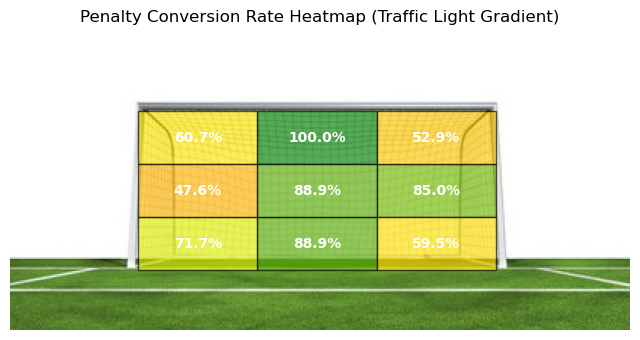

In [10]:
# Load goal image
img = mpimg.imread("Images and others/soccer goal-2.jpg")

fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]], zorder=0)

# Goal pixel bounds
goal_x_start_px = 85
goal_x_end_px = 322
goal_y_start_px = 40
goal_y_end_px = 145

# Map zones to goal coordinates
x_scale = (goal_x_end_px - goal_x_start_px) / 7.32
y_scale = (goal_y_end_px - goal_y_start_px) / 2.44

width_bins = {'L': (0, 2.44), 'C': (2.44, 4.88), 'R': (4.88, 7.32)}
height_bins = {'T': (1.63, 2.44), 'M': (0.81, 1.63), 'D': (0, 0.81)}  # top to bottom

# Gradient traffic-light colormap: red -> yellow -> green
cmap = mcolors.LinearSegmentedColormap.from_list('traffic_light', ['red', 'yellow', 'green'])
norm = colors.TwoSlopeNorm(vmin=0, vcenter=overall_conversion_rate_pct, vmax=100)

# Overlay zones with colored rectangles and conversion rate text
for _, row in outcomes_by_zone.iterrows():
    wz = row["Width"]
    hz = row["Height"]

    if wz not in width_bins or hz not in height_bins:
        continue

    x0, x1 = width_bins[wz]
    y0, y1 = height_bins[hz]

    # Convert to pixel coordinates
    px0 = goal_x_start_px + x0 * x_scale
    px1 = goal_x_start_px + x1 * x_scale
    py0 = goal_y_start_px + y0 * y_scale
    py1 = goal_y_start_px + y1 * y_scale

    # Rectangle colored by conversion rate
    ax.add_patch(
        Rectangle(
            (px0, py0),
            px1 - px0,
            py1 - py0,
            facecolor=cmap(norm(row['conversion_rate_pct'])),
            alpha=0.65,
            edgecolor="black",
            zorder=2
        )
    )

    # Add text: conversion rate in %
    ax.text(
        (px0 + px1)/2,  # center x
        (py0 + py1)/2,  # center y
        f"{row['conversion_rate_pct']:.1f}%",  # show as percentage
        color='black' if row['conversion_rate_pct'] <= 0 else 'white',  # contrast text
        ha='center',
        va='center',
        fontsize=10,
        fontweight='bold',
        zorder=3
    )

ax.axis("off")
plt.title("Penalty Conversion Rate Heatmap (Traffic Light Gradient)")
plt.show()

In [44]:

# Prepare data

df = outcomes_by_zone.copy()
df["is_middle"] = (df["Width"] == "C").astype(int)

summary = (
    df.groupby("is_middle")
    .agg(
        goals=("goals_FG", "sum"),
        attempts=("attempts", "sum")
    )
)

summary["conversion_rate"] = summary["goals"] / summary["attempts"]
summary["conversion_rate_pct"] = summary["conversion_rate"] * 100

print("Summary by zone:\n")
print(summary)


# Hypothesis 1: Conversion rate
# H0: Middle conversion rate <= Non-middle
# H1: Middle conversion rate > Non-middle

middle = summary.loc[1]
not_middle = summary.loc[0]

count = [middle["goals"], not_middle["goals"]]
nobs = [middle["attempts"], not_middle["attempts"]]

z_stat, p_conv = proportions_ztest(count, nobs, alternative="larger")

max_conf_conv = (1 - p_conv) * 100  # Maximum confidence level

print("\n--- Conversion Rate Test ---")
print(f"Middle conversion rate: {middle['conversion_rate']:.3f} ({middle['conversion_rate_pct']:.1f}%)")
print(f"Non-middle conversion rate: {not_middle['conversion_rate']:.3f} ({not_middle['conversion_rate_pct']:.1f}%)")
print(f"z-stat = {z_stat:.4f}, p-value = {p_conv:.4f}")
print(f"Maximum confidence to reject H₀: {max_conf_conv:.1f}%")

# Certainty levels
for alpha, level in zip([0.10, 0.05, 0.01], ["90%", "95%", "99%"]):
    if p_conv < alpha:
        print(f"Reject H₀ at {level} confidence ✅")
    else:
        print(f"Fail to reject H₀ at {level} confidence ❌")


# Hypothesis 2: Attempt frequency
# H0: Middle penalties attempted equally often as non-middle
# H1: Middle penalties attempted less often

observed_attempts = [middle["attempts"], not_middle["attempts"]]

chi2_stat, p_freq = chisquare(observed_attempts)

max_conf_freq = (1 - p_freq) * 100  # Maximum confidence level

print("\n--- Attempt Frequency Test ---")
print(f"Attempts (Middle): {middle['attempts']}")
print(f"Attempts (Non-Middle): {not_middle['attempts']}")
print(f"chi² = {chi2_stat:.4f}, p-value = {p_freq:.50f}")
print(f"Maximum confidence to reject H₀: {max_conf_freq:.1f}%")

# Certainty levels
for alpha, level in zip([0.10, 0.05, 0.01], ["90%", "95%", "99%"]):
    if p_freq < alpha:
        print(f"Reject H₀ at {level} confidence ✅")
    else:
        print(f"Fail to reject H₀ at {level} confidence ❌")

Summary by zone:

           goals  attempts  conversion_rate  conversion_rate_pct
is_middle                                                       
0            121       188         0.643617            64.361702
1             22        24         0.916667            91.666667

--- Conversion Rate Test ---
Middle conversion rate: 0.917 (91.7%)
Non-middle conversion rate: 0.644 (64.4%)
z-stat = 2.6884, p-value = 0.0036
Maximum confidence to reject H₀: 99.6%
Reject H₀ at 90% confidence ✅
Reject H₀ at 95% confidence ✅
Reject H₀ at 99% confidence ✅

--- Attempt Frequency Test ---
Attempts (Middle): 24.0
Attempts (Non-Middle): 188.0
chi² = 126.8679, p-value = 0.00000000000000000000000000001985574271342832498040
Maximum confidence to reject H₀: 100.0%
Reject H₀ at 90% confidence ✅
Reject H₀ at 95% confidence ✅
Reject H₀ at 99% confidence ✅


# World Cups dataset

https://www.kaggle.com/datasets/pablollanderos33/world-cup-penalty-shootouts

In [12]:
WorldCupShootouts = pd.read_csv("Datasets/Penalty Data/WorldCupShootouts.csv")
WorldCupShootouts.head()

# https://www.kaggle.com/datasets/pablollanderos33/world-cup-penalty-shootouts

,Game_id,Team,Zone,Foot,Keeper,OnTarget,Goal,Penalty_Number,Elimination
0,1,FRA,7.0,R,R,1.0,1.0,1,0.0
1,1,GER,9.0,R,C,1.0,1.0,2,0.0
2,1,FRA,6.0,R,L,1.0,1.0,3,0.0
3,1,GER,2.0,R,C,1.0,1.0,4,0.0
4,1,FRA,9.0,R,L,1.0,1.0,5,0.0


In [13]:
len(WorldCupShootouts)

304

In [14]:
shootouts = (
    WorldCupShootouts.groupby("Game_id")
      .agg(
          teams=("Team", lambda x: sorted(x.unique())),
          n_penalties=("Penalty_Number", "max")
      )
      .reset_index()
)

In [15]:
game_id_to_year = {
    1: 1982,   # FRA vs GER
    2: 1986,   # BRA vs FRA
    3: 1986,   # GER vs MEX
    4: 1986,   # BEL vs SPA
    5: 1990,   # IRE vs ROM
    6: 1990,   # ARG vs YUG
    7: 1990,   # ARG vs ITA
    8: 1990,   # ENG vs GER
    9: 1994,   # BUL vs MEX
    10: 1994,  # RUM vs SWE
    11: 1994,  # BRA vs ITA (Final)
    12: 1998,  # ARG vs ENG
    13: 1998,  # FRA vs ITA
    14: 1998,  # BRA vs HOL
    15: 2002,  # IRE vs SPA
    16: 2002,  # KOR vs SPA
    17: 2006,  # SWZ vs UKR
    18: 2006,  # ARG vs GER
    19: 2006,  # ENG vs POR
    20: 2006,  # FRA vs ITA (Final)
    21: 2010,  # JAP vs PAR
    22: 2010,  # GHA vs URU
    23: 2014,  # BRA vs CHI
    24: 2014,  # CRA vs GRE
    25: 2014,  # CRA vs HOL
    26: 2014,  # ARG vs HOL
    27: 2018,  # RUS vs SPA
    28: 2018,  # CRO vs DEN
    29: 2018,  # COL vs ENG
    30: 2018   # CRO vs RUS
}

In [16]:
WorldCupShootouts["Year"] = WorldCupShootouts["Game_id"].map(game_id_to_year)
shootouts["Year"] = shootouts["Game_id"].map(game_id_to_year)
shootouts.sort_values("Year")[["Game_id", "teams", "Year"]].tail()

,Game_id,teams,Year
25,26,"[ARG, HOL]",2014
26,27,"[RUS, SPA]",2018
27,28,"[CRO, DEN]",2018
28,29,"[COL, ENG]",2018
29,30,"[CRO, RUS]",2018


In [17]:
WorldCupShootouts.head()

,Game_id,Team,Zone,Foot,Keeper,OnTarget,Goal,Penalty_Number,Elimination,Year
0,1,FRA,7.0,R,R,1.0,1.0,1,0.0,1982
1,1,GER,9.0,R,C,1.0,1.0,2,0.0,1982
2,1,FRA,6.0,R,L,1.0,1.0,3,0.0,1982
3,1,GER,2.0,R,C,1.0,1.0,4,0.0,1982
4,1,FRA,9.0,R,L,1.0,1.0,5,0.0,1982


In [18]:
# Total goals
total_goals_wc = (WorldCupShootouts['Goal'] == 1).sum()

# Total attempts
total_attempts_wc = len(WorldCupShootouts)

# Conversion rate
overall_conversion_rate_wc = total_goals_wc / total_attempts_wc
overall_conversion_rate_wc_pct = overall_conversion_rate_wc * 100

print(f"Overall conversion rate: {overall_conversion_rate_wc:.3f} ({overall_conversion_rate_wc_pct:.1f}%)")

Overall conversion rate: 0.641 (64.1%)


In [19]:
# Count shot outcomes per zone


# Map "shot_outcome" equivalent:
# We'll create 3 categories: goals, miss off-target, saved on-target
def map_outcome(row):
    if row["Goal"] == 1:
        return "goals_FG"
    elif row["OnTarget"] == 1 and row["Goal"] == 0:
        return "save_FS"  # shot on target but saved
    else:
        return "miss_FO"  # shot off-target

WorldCupShootouts["shot_outcome"] = WorldCupShootouts.apply(map_outcome, axis=1)

# Group by Zone and shot_outcome
outcomes_by_zone_wc = (
    WorldCupShootouts
    .groupby(["Zone", "shot_outcome"])
    .size()
    .unstack(fill_value=0)
)

# Ensure all columns exist
for col in ["goals_FG", "miss_FO", "save_FS"]:
    if col not in outcomes_by_zone_wc.columns:
        outcomes_by_zone_wc[col] = 0

# Remove columns index name
outcomes_by_zone_wc.columns.name = None

# Total attempts
outcomes_by_zone_wc["attempts"] = outcomes_by_zone_wc.sum(axis=1)

# Conversion metrics
outcomes_by_zone_wc["conversion_rate"] = outcomes_by_zone_wc["goals_FG"] / outcomes_by_zone_wc["attempts"]
outcomes_by_zone_wc["conversion_rate_pct"] = (outcomes_by_zone_wc["conversion_rate"] * 100).round(1)

# Make Zone a column
outcomes_by_zone_wc = outcomes_by_zone_wc.reset_index()

# Width mapping (Left/Center/Right)
outcomes_by_zone_wc["Width"] = outcomes_by_zone_wc["Zone"].map({
    1: "C", 2: "C", 3: "C",
    4: "L", 5: "L", 6: "L",
    7: "R", 8: "R", 9: "R"
})

# Height mapping (Top/Medium/Bottom)
outcomes_by_zone_wc["Height"] = outcomes_by_zone_wc["Zone"].map({
    1: "D", 4: "D", 7: "D",
    2: "M", 5: "M", 8: "M",
    3: "T", 6: "T", 9: "T"
})

# Final column order
outcomes_by_zone_wc = outcomes_by_zone_wc[
    [
        "Zone",
        "Height",
        "Width",
        "goals_FG",
        "miss_FO",
        "save_FS",
        "attempts",
        "conversion_rate",
        "conversion_rate_pct",
    ]
]

# Sort nicely: highest conversion rate, then attempts
outcomes_by_zone_wc = outcomes_by_zone_wc.sort_values(["conversion_rate_pct", "attempts"], ascending=[False, False])

outcomes_by_zone_wc

,Zone,Height,Width,goals_FG,miss_FO,save_FS,attempts,conversion_rate,conversion_rate_pct
2,3.0,T,C,14,2,0,16,0.875000,87.5
5,6.0,T,L,25,1,7,33,0.757576,75.8
3,4.0,D,L,27,1,8,36,0.750000,75.0
0,1.0,D,C,21,6,1,28,0.750000,75.0
8,9.0,T,R,34,1,11,46,0.739130,73.9
6,7.0,D,R,40,5,18,63,0.634921,63.5
4,5.0,M,L,11,0,7,18,0.611111,61.1
7,8.0,M,R,12,0,8,20,0.600000,60.0
1,2.0,M,C,11,7,1,19,0.578947,57.9


In [20]:

# Prepare data

# Add "is_middle" column
outcomes_by_zone_wc["is_middle"] = (outcomes_by_zone_wc["Width"] == "C").astype(int)

# Aggregate goals and attempts by middle vs non-middle
summary = (
    outcomes_by_zone_wc.groupby("is_middle")
    .agg(
        goals=("goals_FG", "sum"),
        attempts=("attempts", "sum")
    )
)

summary["conversion_rate"] = summary["goals"] / summary["attempts"]
summary["conversion_rate_pct"] = summary["conversion_rate"] * 100

print("Summary by zone:\n")
print(summary)


# Hypothesis 1: Conversion rate
# H0: Middle conversion rate <= Non-middle
# H1: Middle conversion rate > Non-middle

middle = summary.loc[1]
not_middle = summary.loc[0]

count = [middle["goals"], not_middle["goals"]]
nobs = [middle["attempts"], not_middle["attempts"]]

z_stat, p_conv = proportions_ztest(count, nobs, alternative="larger")
max_conf_conv = (1 - p_conv) * 100  # Maximum confidence to reject H0

print("\n--- Conversion Rate Test ---")
print(f"Middle conversion rate: {middle['conversion_rate']:.3f} ({middle['conversion_rate_pct']:.1f}%)")
print(f"Non-middle conversion rate: {not_middle['conversion_rate']:.3f} ({not_middle['conversion_rate_pct']:.1f}%)")
print(f"z-stat = {z_stat:.3f}, p-value = {p_conv:.4f}")
print(f"Maximum confidence to reject H₀: {max_conf_conv:.1f}%")

for alpha, level in zip([0.10, 0.05, 0.01], ["90%", "95%", "99%"]):
    if p_conv < alpha:
        print(f"Reject H₀ at {level} confidence ✅")
    else:
        print(f"Fail to reject H₀ at {level} confidence ❌")


# Hypothesis 2: Attempt frequency
# H0: Middle penalties attempted equally often as non-middle
# H1: Middle penalties attempted less often

observed_attempts = [middle["attempts"], not_middle["attempts"]]

chi2_stat, p_freq = chisquare(observed_attempts)
max_conf_freq = (1 - p_freq) * 100

print("\n--- Attempt Frequency Test ---")
print(f"Attempts (Middle): {middle['attempts']}")
print(f"Attempts (Non-Middle): {not_middle['attempts']}")
print(f"chi² = {chi2_stat:.3f}, p-value = {p_freq:.4f}")
print(f"Maximum confidence to reject H₀: {max_conf_freq:.1f}%")

for alpha, level in zip([0.10, 0.05, 0.01], ["90%", "95%", "99%"]):
    if p_freq < alpha:
        print(f"Reject H₀ at {level} confidence ✅")
    else:
        print(f"Fail to reject H₀ at {level} confidence ❌")

Summary by zone:

           goals  attempts  conversion_rate  conversion_rate_pct
is_middle                                                       
0            149       216         0.689815            68.981481
1             46        63         0.730159            73.015873

--- Conversion Rate Test ---
Middle conversion rate: 0.730 (73.0%)
Non-middle conversion rate: 0.690 (69.0%)
z-stat = 0.614, p-value = 0.2695
Maximum confidence to reject H₀: 73.0%
Fail to reject H₀ at 90% confidence ❌
Fail to reject H₀ at 95% confidence ❌
Fail to reject H₀ at 99% confidence ❌

--- Attempt Frequency Test ---
Attempts (Middle): 63.0
Attempts (Non-Middle): 216.0
chi² = 83.903, p-value = 0.0000
Maximum confidence to reject H₀: 100.0%
Reject H₀ at 90% confidence ✅
Reject H₀ at 95% confidence ✅
Reject H₀ at 99% confidence ✅


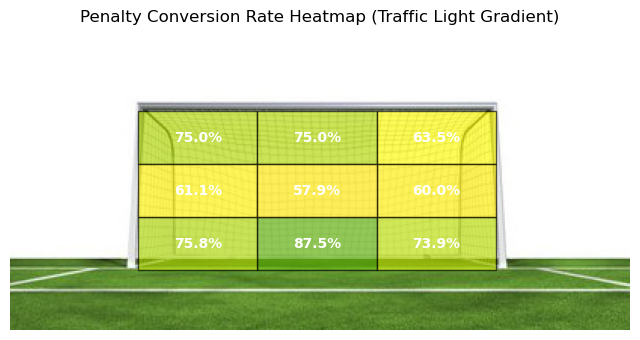

In [21]:
# Compute overall conversion rate % for centering the colormap
overall_conversion_rate_pct = outcomes_by_zone_wc["conversion_rate_pct"].mean()

# Load goal image
img = mpimg.imread("Images and others/soccer goal-2.jpg")

fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(img, extent=[0, img.shape[1], 0, img.shape[0]], zorder=0)

# Goal pixel bounds
goal_x_start_px = 85
goal_x_end_px = 322
goal_y_start_px = 40
goal_y_end_px = 145

# Scale: meters to pixels
x_scale = (goal_x_end_px - goal_x_start_px) / 7.32
y_scale = (goal_y_end_px - goal_y_start_px) / 2.44

# Zone mapping
width_bins = {'L': (0, 2.44), 'C': (2.44, 4.88), 'R': (4.88, 7.32)}
height_bins = {'T': (1.63, 2.44), 'M': (0.81, 1.63), 'D': (0, 0.81)}  # top to bottom

# Traffic-light colormap
cmap = mcolors.LinearSegmentedColormap.from_list('traffic_light', ['red', 'yellow', 'green'])
norm = colors.TwoSlopeNorm(vmin=0, vcenter=overall_conversion_rate_wc_pct, vmax=100)

# Overlay zones
for _, row in outcomes_by_zone_wc.iterrows():
    wz = row["Width"]
    hz = row["Height"]

    if wz not in width_bins or hz not in height_bins:
        continue

    x0, x1 = width_bins[wz]
    y0, y1 = height_bins[hz]

    # Convert meters to pixels
    px0 = goal_x_start_px + x0 * x_scale
    px1 = goal_x_start_px + x1 * x_scale

    # Invert y-axis because image origin is top-left
    py0 = goal_y_start_px + (2.44 - y1) * y_scale
    py1 = goal_y_start_px + (2.44 - y0) * y_scale

    # Rectangle colored by conversion rate
    ax.add_patch(
        Rectangle(
            (px0, py0),
            px1 - px0,
            py1 - py0,
            facecolor=cmap(norm(row['conversion_rate_pct'])),
            alpha=0.65,
            edgecolor="black",
            zorder=2
        )
    )

    # Add conversion rate text
    ax.text(
        (px0 + px1)/2,
        (py0 + py1)/2,
        f"{row['conversion_rate_pct']:.1f}%",
        color='white' if row['conversion_rate_pct'] > 0 else 'black',
        ha='center',
        va='center',
        fontsize=10,
        fontweight='bold',
        zorder=3
    )

ax.axis("off")
plt.title("Penalty Conversion Rate Heatmap (Traffic Light Gradient)")
plt.show()


In [22]:
# Full sentences summary

# Conversion rate
print("\n--- Conversion Rate Conclusion ---")
sentence_conv = f"Middle penalties have a conversion rate of {middle['conversion_rate_pct']:.1f}%, "\
                f"while non-middle penalties have a conversion rate of {not_middle['conversion_rate_pct']:.1f}%. "\
                f"The z-statistic is {z_stat:.3f} with a p-value of {p_conv:.4f}. "\
                f"Maximum confidence to reject H₀: {max_conf_conv:.1f}%.\n"

for alpha, level in zip([0.10, 0.05, 0.01], ["90%", "95%", "99%"]):
    if p_conv < alpha:
        sentence_conv += f"At {level} confidence, we reject H₀ — middle penalties are converted at a higher rate.\n"
    else:
        sentence_conv += f"At {level} confidence, we fail to reject H₀ — no significant conversion advantage for middle penalties.\n"

print(sentence_conv)

# Attempt frequency
print("\n--- Attempt Frequency Conclusion ---")
sentence_freq = f"Middle penalties were attempted {middle['attempts']} times, "\
                f"while non-middle penalties were attempted {not_middle['attempts']} times. "\
                f"The chi-square statistic is {chi2_stat:.3f} with a p-value of {p_freq:.4f}. "\
                f"Maximum confidence to reject H₀: {max_conf_freq:.1f}%.\n"

for alpha, level in zip([0.10, 0.05, 0.01], ["90%", "95%", "99%"]):
    if p_freq < alpha:
        sentence_freq += f"At {level} confidence, we reject H₀ — middle penalties are attempted less frequently.\n"
    else:
        sentence_freq += f"At {level} confidence, we fail to reject H₀ — no significant difference in attempt frequency.\n"

print(sentence_freq)



--- Conversion Rate Conclusion ---
Middle penalties have a conversion rate of 73.0%, while non-middle penalties have a conversion rate of 69.0%. The z-statistic is 0.614 with a p-value of 0.2695. Maximum confidence to reject H₀: 73.0%.
At 90% confidence, we fail to reject H₀ — no significant conversion advantage for middle penalties.
At 95% confidence, we fail to reject H₀ — no significant conversion advantage for middle penalties.
At 99% confidence, we fail to reject H₀ — no significant conversion advantage for middle penalties.


--- Attempt Frequency Conclusion ---
Middle penalties were attempted 63.0 times, while non-middle penalties were attempted 216.0 times. The chi-square statistic is 83.903 with a p-value of 0.0000. Maximum confidence to reject H₀: 100.0%.
At 90% confidence, we reject H₀ — middle penalties are attempted less frequently.
At 95% confidence, we reject H₀ — middle penalties are attempted less frequently.
At 99% confidence, we reject H₀ — middle penalties are atte

# Frequency plots (both datasets)

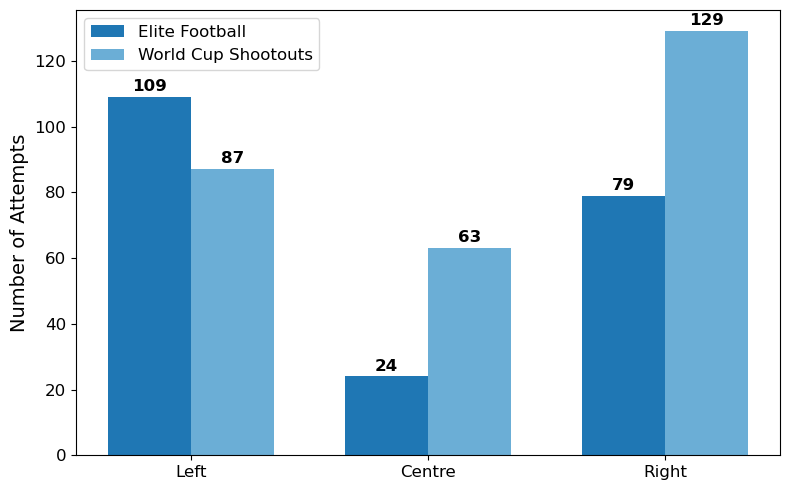

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Summarise attempts by Left/Centre/Right ---
def summarise_by_side(df):
    side_map = {'L': 'Left', 'C': 'Centre', 'R': 'Right'}
    df['Side'] = df['Width'].map(side_map)
    summary = df.groupby('Side')['attempts'].sum().reindex(['Left', 'Centre', 'Right'])
    return summary

elite_summary = summarise_by_side(outcomes_by_zone)
wc_summary = summarise_by_side(outcomes_by_zone_wc)

# --- Plotting ---
labels = ['Left', 'Centre', 'Right']
x = np.arange(len(labels))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(8,5))  # keep original figure size

# Two shades of blue
elite_color = '#1f77b4'  # darker blue
wc_color = '#6baed6'     # lighter blue

rects1 = ax.bar(x - width/2, elite_summary.values, width, label='Elite Football', color=elite_color)
rects2 = ax.bar(x + width/2, wc_summary.values, width, label='World Cup Shootouts', color=wc_color)

# Labels, title, legend with bigger font
ax.set_ylabel('Number of Attempts', fontsize=14)
#ax.set_title('Penalty Attempt Frequency by Side and Dataset', fontsize=16, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12)

# Add value labels on top of bars with bigger font
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,2),  # spacing above bar
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=12, weight='bold')  # bigger, bold numbers

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Summarise attempts by Left/Centre/Right ---
def summarise_by_side(df):
    side_map = {'L': 'Left', 'C': 'Centre', 'R': 'Right'}
    df['Side'] = df['Width'].map(side_map)
    summary = df.groupby('Side')['attempts'].sum().reindex(['Left', 'Centre', 'Right'])
    return summary

elite_summary = summarise_by_side(outcomes_by_zone)
wc_summary = summarise_by_side(outcomes_by_zone_wc)

# --- Plotting ---
labels = ['Left', 'Centre', 'Right']
x = np.arange(len(labels))  # label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(8,5))  # keep original figure size

# Two shades of blue
elite_color = '#1f77b4'  # darker blue
wc_color = '#6baed6'     # lighter blue

rects1 = ax.bar(x - width/2, elite_summary.values, width, label='Elite Football', color=elite_color)
rects2 = ax.bar(x + width/2, wc_summary.values, width, label='World Cup Shootouts', color=wc_color)

# Labels, title, legend with bigger font
ax.set_ylabel('Number of Attempts', fontsize=14)
#ax.set_title('Penalty Attempt Frequency by Side and Dataset', fontsize=16, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12)

# Add value labels on top of bars with bigger font
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,2),  # spacing above bar
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=12, weight='bold')  # bigger, bold numbers

plt.tight_layout()
plt.show()

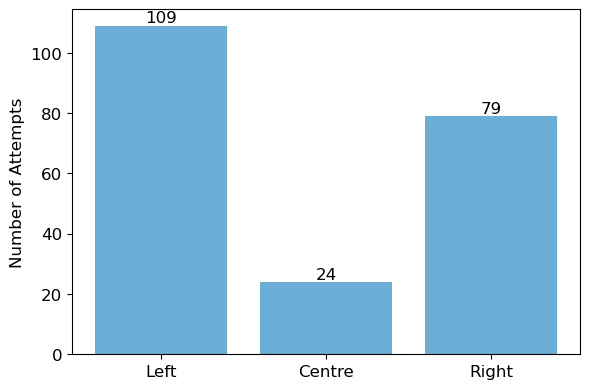

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Summarise attempts by Left/Centre/Right ---
def summarise_by_side(df):
    side_map = {'L': 'Left', 'C': 'Centre', 'R': 'Right'}
    df = df.copy()
    df['Side'] = df['Width'].map(side_map)
    summary = df.groupby('Side')['attempts'].sum().reindex(['Left', 'Centre', 'Right'])
    return summary

elite_summary = summarise_by_side(outcomes_by_zone)

# --- Plotting ---
labels = ['Left', 'Centre', 'Right']
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(6, 4))  # same size as before

elite_color = '#6baed6'  # blue

bars = ax.bar(x, elite_summary.values, color=elite_color)

# Labels and formatting
ax.set_ylabel('Number of Attempts', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.tick_params(axis='y', labelsize=12)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 0),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=12) #, weight='bold')

plt.tight_layout()
plt.show()